Reference: 
**S. M. Konishi, A.L. Yuille, J.M. Coughlan and S.C. Zhu. Statistical Edge Detection: Learning and Evaluating Edge Cues. IEEE Transactions on Pattern Analysis and Machine Intelligence. TPAMI. Vol. 25, No. 1, pp 57-74. January 2003.**

The homework questions are at the end, but run through the notebook step-by-step to make sure you have an idea what it's doing!

# Initialization and define some utility functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def myimshow(im):
    plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.gray())

# Read image and edge map

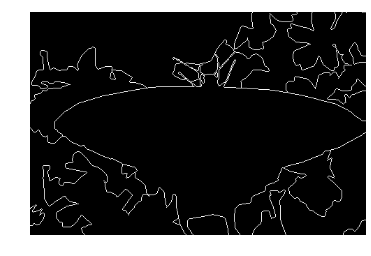

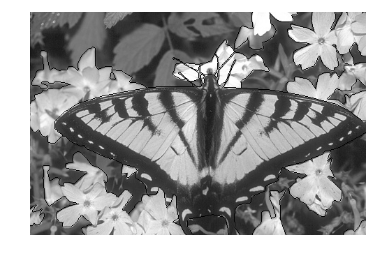

In [15]:
# Show image and edge labeling
# id = '100075'
id = '35010' # butterfly
# id = '97017' # building
# id = '41004' # deer
# Change the id to try a different image

def loadData(id):
    from skimage.color import rgb2gray
    edgeMap = plt.imread('data/edge/boundaryMap/' + id + '.bmp'); edgeMap = edgeMap[:,:,0]
    im = plt.imread('data/edge/trainImgs/' + id + '.jpg')
    grayIm = rgb2gray(im)
    return [grayIm, edgeMap]

[im, edgeMap] = loadData(id)
myimshow(edgeMap); # title('Boundary')
myimshow(im * (edgeMap==0)); # title('Image with boundary')

# Define function to filter image 
$ \frac{dI}{dx} $, $ \frac{dG*I}{dx} $

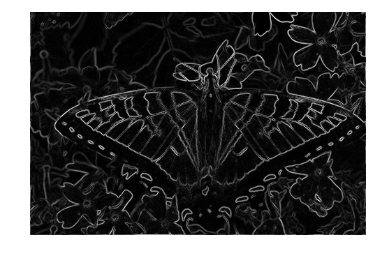

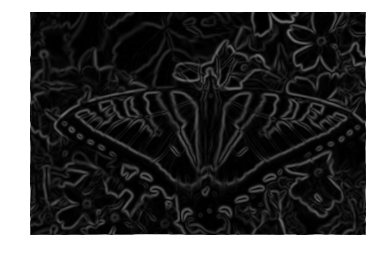

In [16]:
def dIdx(im):
    # Compute magnitude of gradient
    # 'CentralDifference' : Central difference gradient dI/dx = (I(x+1)- I(x-1))/ 2
    dx = (np.roll(im, 1, axis=1) - np.roll(im, -1, axis=1))/2
    dy = (np.roll(im, 1, axis=0) - np.roll(im, -1, axis=0))/2
    mag = np.sqrt(dx**2 + dy**2)
    return mag

def dgIdx(im, sigma=1.5):
    from scipy.ndimage import gaussian_filter
    gauss = gaussian_filter(im, sigma = sigma)
    dgauss = dIdx(gauss)
    return dgauss

dx = dIdx(im)
dgI = dgIdx(im)

# Show filtered images
myimshow(dx); # title(r'$ \frac{dI}{dx} $')
myimshow(dgI); # title(r'$ \frac{d G*I}{dx} $')

# def showEdge(im, edgeMap):
#     # draw edge pixel
#     im = im * (edgeMap != 0)
#     figure(); myimshow(im); title('Highlight edge')

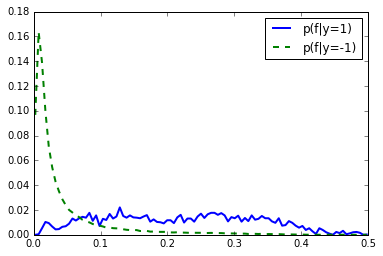

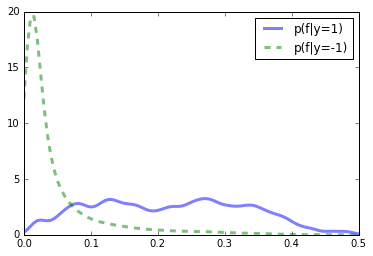

In [17]:
def kde(x):
    # Kernel density estimation, to get P(dI/dx | on edge) and P(dI/dx | off edge) from data
    from scipy.stats import gaussian_kde
    f = gaussian_kde(x, bw_method=0.01 / x.std(ddof=1))
    return f
    
def ponEdge(im, edgeMap):
    # Compute on edge histogram
    # im is filtered image
    
    # Convert edge map to pixel index
    flattenEdgeMap = edgeMap.flatten()
    edgeIdx = [i for i in range(len(flattenEdgeMap)) if flattenEdgeMap[i]]
    
    # find edge pixel in 3x3 region, shift the edge map a bit, in case of inaccurate boundary labeling
    [offx, offy] = np.meshgrid(np.arange(-1,2), np.arange(-1,2)); offx = offx.flatten(); offy = offy.flatten()
    maxVal = np.copy(im)
    for i in range(9):
        im1 = np.roll(im, offx[i], axis=1) # x axis
        im1 = np.roll(im1, offy[i], axis=0) # y axis    
        maxVal = np.maximum(maxVal, im1)

    vals = maxVal.flatten()
    onEdgeVals = vals[edgeIdx]
    
    bins = np.linspace(0,0.5, 100)
    [n, bins] = np.histogram(onEdgeVals, bins=bins)
    # n = n+1 # Avoid divide by zero

    pon = kde(onEdgeVals)

    return [n, bins, pon]


def poffEdge(im, edgeMap):
    flattenEdgeMap = edgeMap.flatten()
    noneEdgeIdx = [i for i in range(len(flattenEdgeMap)) if not flattenEdgeMap[i]]
    
    vals = im.flatten()
    offEdgeVals = vals[noneEdgeIdx] 

    bins = np.linspace(0,0.5, 100)
    n, bins = np.histogram(offEdgeVals, bins=bins)

    # n = n+1
    # p = n / sum(n)
    
    poff = kde(offEdgeVals)
    
    return [n, bins, poff]

dx = dIdx(im)
[n1, bins, pon] = ponEdge(dx, edgeMap)
[n2, bins, poff] = poffEdge(dx, edgeMap)

plt.figure(); # Plot on edge
# title('(Normalized) Histogram of on/off edge pixels')
plt.plot((bins[:-1] + bins[1:])/2, n1.astype(float)/sum(n1), '-', lw=2, label="p(f|y=1)")
plt.plot((bins[:-1] + bins[1:])/2, n2.astype(float)/sum(n2), '--', lw=2, label="p(f|y=-1)")
plt.legend()

plt.figure()
# title('Density function of on/off edge pixels')
plt.plot(bins, pon(bins), '-', alpha=0.5, lw=3, label="p(f|y=1)")
plt.plot(bins, poff(bins), '--', alpha=0.5, lw=3, label="p(f|y=-1)")
plt.legend()

# Compute $ P(\frac{dI}{dx} | \text{on edge}) $ and $ P(\frac{dI}{dx} | \text{off edge}) $

CPU times: user 25.9 s, sys: 559 ms, total: 26.5 s
Wall time: 15 s


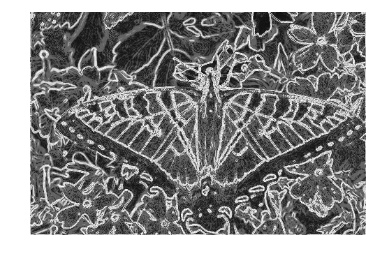

In [18]:
%%time
ponIm = pon(dx.flatten()).reshape(dx.shape) # evaluate pon on a vector and reshape the vector to the image size
myimshow(ponIm)

CPU times: user 14min, sys: 18.2 s, total: 14min 19s
Wall time: 7min 51s


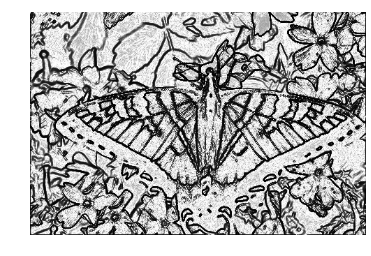

In [19]:
%%time
poffIm = poff(dx.flatten()).reshape(dx.shape) # Slow, evaluation of this cell may take several minutes
myimshow(poffIm)

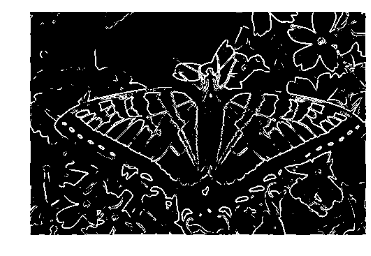

In [20]:
T = 1
myimshow(np.log(ponIm/poffIm)>T) # 

# Show ROC curve (trade off between true and false positives)

In [21]:
gt = (edgeMap!=0) # Ground-truth labels
print np.sum(gt == True) # Edge
print np.sum(gt == False) # Non-edge

4347
150054


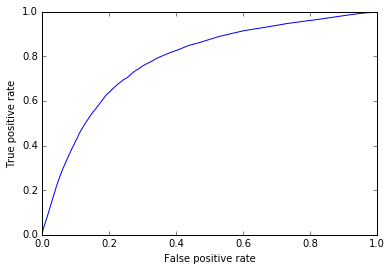

In [22]:
def ROCpoint(predict, gt):
    # predict = (log(ponIm/poffIm)>=T)
    truePos = (predict==True) & (gt == predict)
    trueNeg = (predict==False) & (gt == predict)

    falsePos = (predict==True) & (gt != predict)
    falseNeg = (predict==False) & (gt != predict)

    y = np.double(truePos.sum()) / np.sum(gt == True)
    x = np.double(falsePos.sum()) / np.sum(gt == False)
    return [x, y]

p = []
for T in np.arange(-5, 5, step=0.1):
    predict = (np.log(ponIm/poffIm)>=T)
    p.append(ROCpoint(predict, gt))
x = [v[0] for v in p]
y = [v[1] for v in p]
plt.plot(x, y)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

## Interactive: Change threshold 

Below is an interactive demo to show the result for different threshold T. You can also observe the point on ROC curve.

(Evaluate next cell to run the demo)

<img width="600" src='data/edge/snapshot.png'>

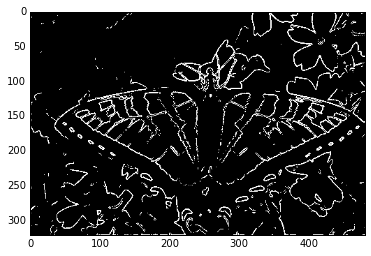

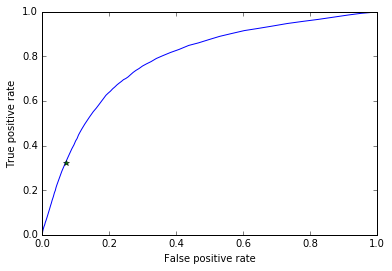

In [23]:
# interactive threshold demo, evaluate this cell
# You can safely skip this cell if you see any error happens.
from IPython.html.widgets import interact, interactive, fixed
def demoThreshold(T):
    predict = (np.log(ponIm/poffIm)>=T)
    plt.figure(1)
    plt.imshow(predict)
    p = ROCpoint(predict, gt)
    plt.figure(2)
    plt.plot(x, y)
    plt.plot(p[0], p[1], '*')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

# compute ROC curve
p = []
for T in np.arange(-5, 5, step=0.1):
    predict = (np.log(ponIm/poffIm)>=T)
    p.append(ROCpoint(predict, gt))
x = [v[0] for v in p]
y = [v[1] for v in p]
    
interact(demoThreshold, T=(-5, 5, 0.1))

# HW2.1:
1. Load another image (e.g. the butterfly or building), apply this edge detection algorithm, find a good threshold and display your result
2. Use $ \frac{dG*I}{dx} $ instead of $\frac{dI}{dx}$ for edge detection where $G$ is a Gaussian. Show results for a couple of different variances `sigma`.

# Compute $ P(\frac{dG*I}{dx} | \text{on edge}) $ and $ P(\frac{dG*I}{dx} | \text{off edge}) $

In [71]:
# for demostration
def plotThreshold(condition, testT):
    ponIm = ponIms[condition]
    poffIm = poffIms[condition]
    gt = (edgeMap!=0) # Ground-truth labels
    # compute ROC curve
    p = []
    for iterT in np.arange(-5, 5, step=0.1):
        predict = (np.log(ponIm/poffIm)>=iterT)
        p.append(ROCpoint(predict, gt))
    x = [v[0] for v in p]
    y = [v[1] for v in p]
    predict = (np.log(ponIm/poffIm)>=testT)
    plt.figure(1)
    plt.imshow(predict)
    p = ROCpoint(predict, gt)
    plt.figure(2)
    plt.plot(x, y)
    plt.plot(p[0], p[1], '*')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

In [72]:
def EdgeDetectionGaussian(sigma = 1.5):
    dgIx = dgIdx(im, sigma)
    [n1, bins, pon] = ponEdge(dgIx, edgeMap)
    [n2, bins, poff] = poffEdge(dgIx, edgeMap)

    plt.figure(); # Plot on edge
    plt.title('(Normalized) Histogram of on/off edge pixels')
    plt.plot((bins[:-1] + bins[1:])/2, n1.astype(float)/sum(n1), '-', lw=2, label="p(f|y=1)")
    plt.plot((bins[:-1] + bins[1:])/2, n2.astype(float)/sum(n2), '--', lw=2, label="p(f|y=-1)")
    plt.legend()

    plt.figure()
    plt.title('Density function of on/off edge pixels')
    plt.plot(bins, pon(bins), '-', alpha=0.5, lw=3, label="p(f|y=1)")
    plt.plot(bins, poff(bins), '--', alpha=0.5, lw=3, label="p(f|y=-1)")
    plt.legend()
    
    ## pon
    print "working on P-ON"
    %%time
    ponIm = pon(dgIx.flatten()).reshape(dgIx.shape) 
    myimshow(ponIm)
    ## poff, time consuming
    print "working on P-OFF"
    %%time
    poffIm = poff(dgIx.flatten()).reshape(dgIx.shape) 
    myimshow(poffIm)
    
    return (ponIm, poffIm)



In [73]:
#A case where sigma = 0.5
nSigmas = 4
step = 0.5
sigmas = (np.arange(nSigmas) + 1) * step
ponIms = [];
poffIms = [];
conditions = np.arange(nSigmas)
print 'conditions:', conditions
print 'sigmas:', sigmas

conditions: [0 1 2 3]
sigmas: [ 0.5  1.   1.5  2. ]


working on P-ON
CPU times: user 19 µs, sys: 11 µs, total: 30 µs
Wall time: 34.1 µs
working on P-OFF
CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 5.96 µs
working on P-ON
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
working on P-OFF
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
working on P-ON
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
working on P-OFF
CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 5.96 µs
working on P-ON
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
working on P-OFF
CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 7.87 µs


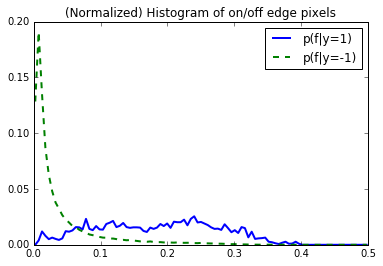

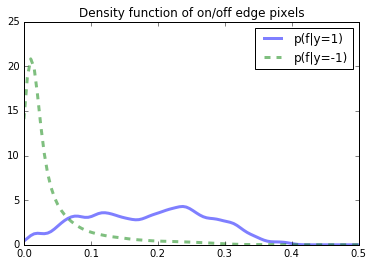

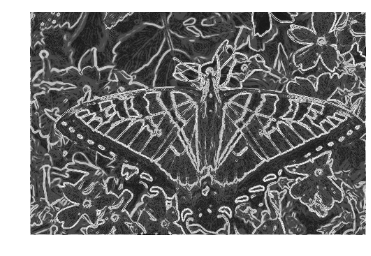

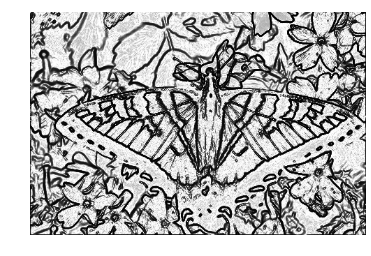

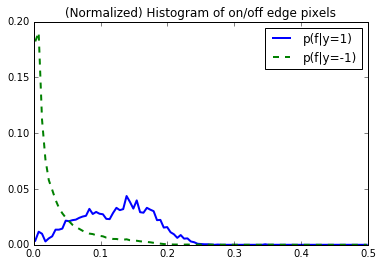

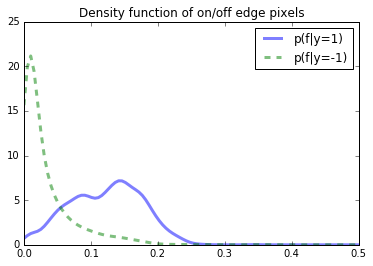

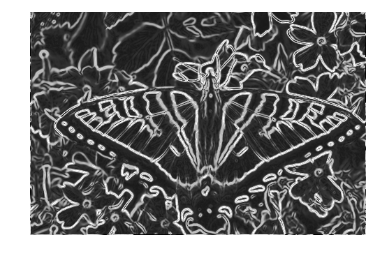

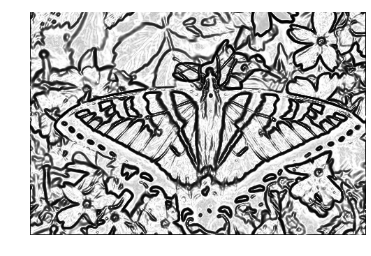

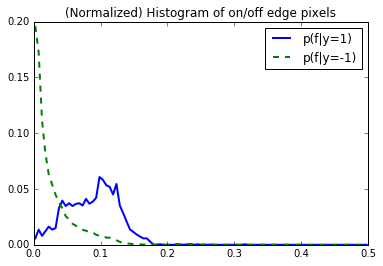

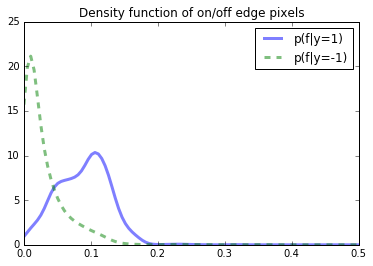

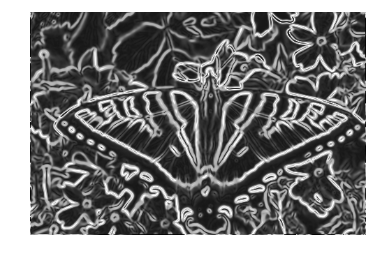

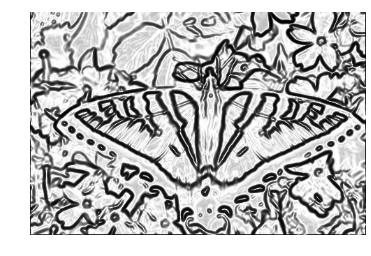

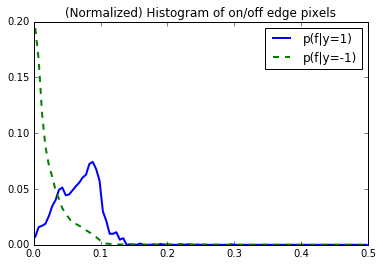

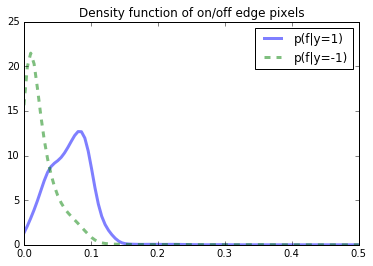

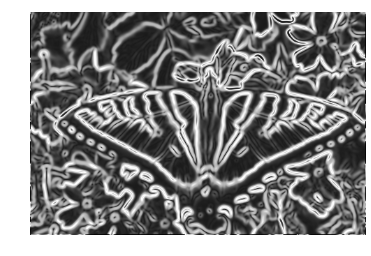

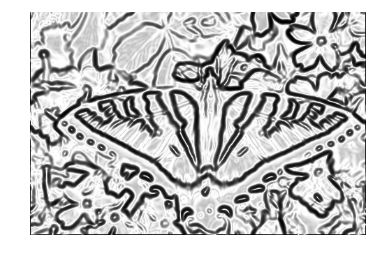

In [74]:
for sigma in sigmas:
    ponTmp, poffTmp = EdgeDetectionGaussian(sigma = sigma)
    ponIms.append(ponTmp)
    poffIms.append(poffTmp)


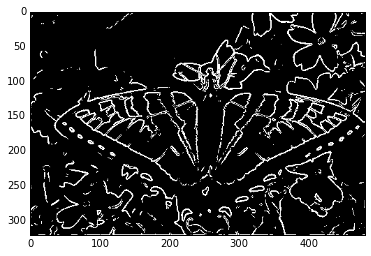

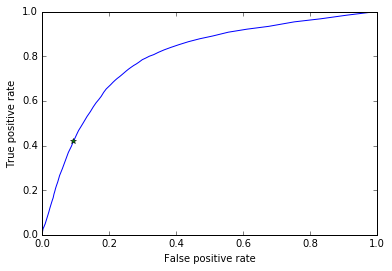

In [77]:
interact(plotThreshold, condition = (0,3,1), testT=(-5, 5, 0.1))
